In [1]:
import datetime as dt
import numpy as np
import polars as pl

from factor_momentum import RollingPCA, FactorMomentumSignal, FACTORS
from factor_momentum._loaders import _scan_monthly_pc_returns
from sf_quant.data import load_factors


/home/boobus/projects/factor_momentum/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-13 19:28:34,788	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [46]:
start = dt.date(2001,1,1); end = dt.date(2020,1,1); factor_returns = load_factors(start,end, FACTORS).lazy()
pca_engine = RollingPCA(n_components=5, lookback_window=100)

In [70]:
pc_returns = pca_engine.fit_transform_rolling_monthly(start, end, factor_returns)
pc_returns

Fitting rolling PCA...


Rolling PCA: 100%|██████████| 227/227 [00:00<00:00, 514.13it/s]


Transforming rolling PCA...


Rolling PCA: 100%|██████████| 227/227 [00:00<00:00, 555.94it/s]


date,pc0,pc1,pc2,pc3,pc4
date,f64,f64,f64,f64,f64
2001-02-01,-1.464667,-1.143598,0.180363,0.551172,1.143439
2001-02-01,-1.481167,-0.150589,0.239467,0.383877,-0.276733
2001-02-01,-0.997846,-0.57137,-0.960766,0.96356,0.80466
2001-02-01,0.441192,-0.101307,-0.564052,-1.315537,-1.572022
2001-02-01,0.071369,0.954979,-0.923436,1.117135,-1.701075
…,…,…,…,…,…
2019-12-02,-0.116428,-1.345718,0.05031,-0.394584,-0.264584
2019-12-02,1.138469,0.198301,1.053526,1.42063,0.196853
2019-12-02,1.530432,0.588633,-0.567155,0.043286,-0.482651


In [74]:
pcs = (pc_returns.unpivot(index='date', variable_name='factor', value_name='ret').lazy()
.with_columns(
    pl.col('date').dt.truncate('1mo').alias('mo'),
)
.group_by(['factor', 'mo']).agg(
    pl.col('date').first().alias('month'),
    (np.log(1 + pl.col('ret')*.01).sum()).alias('ret'),
)
.drop('mo')
.sort(['factor', 'month'])
.with_columns(
    pl.col('ret').shift(1).over('factor').alias('lag_ret')
)
.collect()
)
pcs

factor,month,ret,lag_ret
str,date,f64,f64
"""pc0""",2001-02-01,-0.087645,null
"""pc0""",2001-03-01,-0.010698,-0.087645
"""pc0""",2001-04-02,0.141216,-0.010698
"""pc0""",2001-05-01,-0.02549,0.141216
"""pc0""",2001-06-01,0.03978,-0.02549
…,…,…,…
"""pc4""",2019-08-01,-0.011225,0.021908
"""pc4""",2019-09-03,0.084635,-0.011225
"""pc4""",2019-10-01,-0.014121,0.084635


In [42]:
pcs = _scan_monthly_pc_returns(start, end, 5, 200).collect()
pcs

Fitting rolling PCA...


Rolling PCA: 100%|██████████| 227/227 [00:00<00:00, 435.87it/s]


Transforming rolling PCA...


Rolling PCA: 100%|██████████| 227/227 [00:00<00:00, 454.27it/s]


factor,month,ret,lag_ret
str,date,f64,f64
"""pc0""",2001-02-01,-0.087645,-0.024252
"""pc0""",2001-03-01,-0.010698,-0.086327
"""pc0""",2001-04-02,0.141216,0.045299
"""pc0""",2001-05-01,0.011112,-0.004333
"""pc0""",2001-06-01,0.085766,-0.021743
…,…,…,…
"""pc4""",2019-08-01,0.063565,-0.02297
"""pc4""",2019-09-03,-0.000596,0.043822
"""pc4""",2019-10-01,0.003175,-0.044886


In [75]:
ports = (pcs.with_columns(
    pl.col('lag_ret').rank('dense').over('month').alias('rank')
)
.with_columns(
    pl.when(pl.col('rank') < 3)
    .then(-1)
    .when(pl.col('rank') > 3)
    .then(1)
    .otherwise(0)
    .alias('signal')
)
.group_by(['month', 'signal']).agg(
    pl.col('ret').sum()
)
.sort('month')
.pivot(on='signal', index='month')
)

ports

month,0,1,-1
date,f64,f64,f64
2001-02-01,-0.200769,null,null
2001-03-01,0.059192,-0.065376,0.053941
2001-04-02,0.141216,0.180721,-0.023559
2001-05-01,-0.015385,-0.056776,-0.076031
2001-06-01,0.03978,0.138254,0.041761
…,…,…,…
2019-08-01,-0.111778,0.105474,-0.010949
2019-09-03,-0.006353,-0.021414,0.124942
2019-10-01,-0.018524,0.059257,0.081849


In [76]:
import matplotlib.pyplot as plt

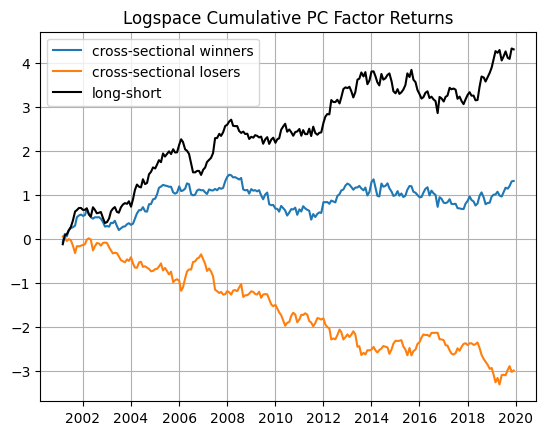

In [89]:
dates = ports['month']

long = ports['1'].cum_sum()
short = ports['-1'].cum_sum()

plt.title("Logspace Cumulative PC Factor Returns")

plt.plot(dates, long, label="cross-sectional winners")
plt.plot(dates, short, label="cross-sectional losers")
plt.plot(dates, long-short, c='black', label="long-short")
plt.legend()
plt.grid(True)
plt.show()

In [86]:
ret = (ports['1']-ports['-1']).mean() * 12
risk = (ports['1']-ports['-1']).std() * np.sqrt(12)

ret/risk

np.float64(0.5572100401844844)